In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
import category_encoders as ce
from prophet import Prophet
import plotly.express as pxd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("./Dataset/preprocessed_dataset_v2.csv", index_col=0)

In [3]:
data.head(100)

,Year,Month,Day,Hour,Minute,Payment Method,Amount,Category,Is Fraud?
0,2002,9,1,6,21,on-site,134.09,Personal Spending,No
1,2002,9,1,6,42,on-site,38.48,Food/Groceries,No
2,2002,9,2,6,22,on-site,120.34,Food/Groceries,No
3,2002,9,2,17,45,on-site,128.95,Clothing,No
4,2002,9,3,6,23,on-site,104.71,Healthcare,No
...,...,...,...,...,...,...,...,...,...
95,2002,10,8,6,24,on-site,100.00,Personal Spending,No
96,2002,10,8,6,26,on-site,154.70,Healthcare,No
97,2002,10,8,8,24,on-site,27.22,Personal Spending,No
98,2002,10,9,6,10,on-site,118.25,Transportation,No


### Convert the date columns to a single datetime column

In [4]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [5]:
data

,Year,Month,Day,Hour,Minute,Payment Method,Amount,Category,Is Fraud?,Date
0,2002,9,1,6,21,on-site,134.09,Personal Spending,No,2002-09-01 06:21:00
1,2002,9,1,6,42,on-site,38.48,Food/Groceries,No,2002-09-01 06:42:00
2,2002,9,2,6,22,on-site,120.34,Food/Groceries,No,2002-09-02 06:22:00
3,2002,9,2,17,45,on-site,128.95,Clothing,No,2002-09-02 17:45:00
4,2002,9,3,6,23,on-site,104.71,Healthcare,No,2002-09-03 06:23:00
...,...,...,...,...,...,...,...,...,...,...
23998444,2020,2,27,22,23,Chip Transaction,-54.00,Transportation,No,2020-02-27 22:23:00
23998445,2020,2,27,22,24,Chip Transaction,54.00,Transportation,No,2020-02-27 22:24:00
23998446,2020,2,28,7,43,Chip Transaction,59.15,Transportation,No,2020-02-28 07:43:00
23998447,2020,2,28,20,10,Chip Transaction,43.12,Transportation,No,2020-02-28 20:10:00


### Group by Year, Month, and Category, then aggregate the data

In [6]:
grouped = data.groupby(['Year', 'Month', 'Category']).agg(
    TotalAmount=('Amount', 'sum')
).reset_index()

### Create a 'ds' column for Prophet

In [7]:
grouped['ds'] = pd.to_datetime(grouped[['Year', 'Month']].assign(DAY=1))

### Prepare a DataFrame for each category

In [8]:
categories = grouped['Category'].unique()
forecasts = {}

In [9]:
for category in categories:
    category_data = grouped[grouped['Category'] == category][['ds', 'TotalAmount']].rename(columns={'TotalAmount': 'y'})
    
    # Split the data into train and test sets
    train, test = train_test_split(category_data, test_size=0.2, shuffle=False)
    
    # Initialize and train the Prophet model
    model = Prophet()
    model.fit(train)
    
    # Make predictions on the test set
    future = model.make_future_dataframe(periods=len(test), freq='M')
    forecast = model.predict(future)
    
    # Store the forecast
    forecasts[category] = forecast

16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.d

### Print the forecast for a specific category

In [10]:
forecasts['Clothing'].tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
345,2019-09-30,556966.299249,530632.691823,600968.193713,526590.269532,593906.816861,5825.563679,5825.563679,5825.563679,5825.563679,5825.563679,5825.563679,0.0,0.0,0.0,562791.862928
346,2019-10-31,558338.462360,523098.337943,594184.626260,527238.614308,596185.569564,-1711.319953,-1711.319953,-1711.319953,-1711.319953,-1711.319953,-1711.319953,0.0,0.0,0.0,556627.142407
347,2019-11-30,559666.362145,528882.221023,601466.571533,527641.126350,598105.134403,2730.161374,2730.161374,2730.161374,2730.161374,2730.161374,2730.161374,0.0,0.0,0.0,562396.523519
348,2019-12-31,561038.525256,524564.398648,603586.812064,528505.094914,599944.337711,92.584790,92.584790,92.584790,92.584790,92.584790,92.584790,0.0,0.0,0.0,561131.110045
349,2020-01-31,562410.688367,516349.920982,594133.236527,529111.038794,601961.315354,-10251.198395,-10251.198395,-10251.198395,-10251.198395,-10251.198395,-10251.198395,0.0,0.0,0.0,552159.489972


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(0.5, 1.0, 'Transoptation Expense Forecast')

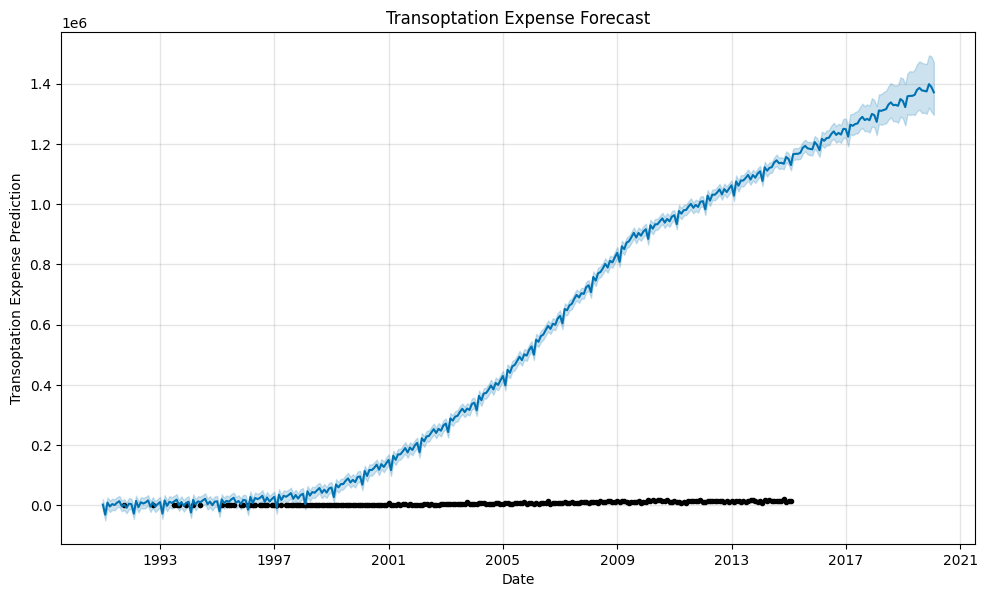

In [11]:
model.plot(forecasts['Transportation'])

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Transoptation Expense Prediction')
plt.title('Transoptation Expense Forecast')

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import matplotlib.pyplot as plt

In [24]:
# data = pd.read_csv("./Dataset/preprocessed_dataset_v2.csv", index_col=0)
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])

grouped = data.groupby(['Year', 'Month', 'Category']).agg(
    TotalAmount=('Amount', 'sum')
).reset_index()

grouped['ds'] = pd.to_datetime(grouped[['Year', 'Month']].assign(DAY=1))

categories = grouped['Category'].unique()
forecasts = {}
evaluation_results = {}
sum=0

for category in categories:
    category_data = grouped[grouped['Category'] == category][['ds', 'TotalAmount']].rename(columns={'TotalAmount': 'y'})
    
    # Split the data into train and test sets
    train, test = train_test_split(category_data, test_size=0.2, shuffle=False)
    
    # Initialize and train the Prophet model
    model = Prophet()
    model.fit(train)
    
    # Make predictions on the test set
    future = model.make_future_dataframe(periods=len(test), freq='M')
    forecast = model.predict(future)
    
    # Store the forecast
    forecasts[category] = forecast
    
    # Evaluate the model
    test_forecast = forecast[-len(test):]  # Get the forecast for the test period
    y_true = test['y'].values
    y_pred = test_forecast['yhat'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    evaluation_results[category] = {'MAE': mae, 'MSE': mse}

    # Print evaluation results
    print(f"Evaluation results for category '{category}':")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print()
    
    Avg=grouped[grouped['Category'] == category]['TotalAmount'].mean()
    print(f"The Average for this category is: {Avg}")
    print()
    sum=sum+Avg
print("The Average for all categories is: ",sum)